In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns

from tabulate import tabulate
from tqdm import trange
import random

from datasets import load_dataset

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoModel

from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import get_scheduler
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
df = pd.read_csv('../input/dataset/dataset.csv')




In [4]:
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,0,f309bce7-7485-4c94-9853-efe16b49200f,nguyen tat dat mai,https://play-lh.googleusercontent.com/a-/AD_cM...,Update xong tìm quanh đây không dùng được nữa....,1,25,19.01.02.medium,2023-06-24 08:44:24,"Chào bạn, hiện tại tính năng này Zalo đang tạm...",2020-09-04 15:52:40,19.01.02.medium
1,1,c7c762a4-e60a-40af-ae3b-c8005fb87e49,Harrier,https://play-lh.googleusercontent.com/a-/AD_cM...,Tính năng liên quan đến số tài khoản ngân hàng...,1,0,23.05.02,2023-06-24 08:32:36,NaN,NaN,23.05.02
2,2,a88a748b-4f11-42de-a536-44e7ddc8659a,Leo 2_1,https://play-lh.googleusercontent.com/a/AAcHTt...,Khi truy cập vào báo rất lag không truy cập được,2,0,23.05.02,2023-06-23 21:39:50,NaN,NaN,23.05.02
3,3,6c243ea9-65ca-40f7-9d68-49a2a6158939,စိုး ေအာင္,https://play-lh.googleusercontent.com/a/AAcHTt...,good for me before,3,0,NaN,2023-06-23 17:05:23,NaN,NaN,NaN
4,4,60c2a70c-8384-4a74-ae6e-b5178ae6944b,Huyền Thanh,https://play-lh.googleusercontent.com/a/AAcHTt...,Không an toàn. Zalo bị phát hiện sử dụng máy ả...,1,0,NaN,2023-06-23 15:35:30,"Chào bạn. Để tiện hỗ trợ bạn hơn, bạn vui lòng...",2023-06-23 15:52:47,NaN


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2



In [8]:
# Apply to the dataset 
df['sentiment'] = df.score.apply(to_sentiment)


In [9]:
df.head(100)

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment
0,0,f309bce7-7485-4c94-9853-efe16b49200f,nguyen tat dat mai,https://play-lh.googleusercontent.com/a-/AD_cM...,Update xong tìm quanh đây không dùng được nữa....,1,25,19.01.02.medium,2023-06-24 08:44:24,"Chào bạn, hiện tại tính năng này Zalo đang tạm...",2020-09-04 15:52:40,19.01.02.medium,0
1,1,c7c762a4-e60a-40af-ae3b-c8005fb87e49,Harrier,https://play-lh.googleusercontent.com/a-/AD_cM...,Tính năng liên quan đến số tài khoản ngân hàng...,1,0,23.05.02,2023-06-24 08:32:36,NaN,NaN,23.05.02,0
2,2,a88a748b-4f11-42de-a536-44e7ddc8659a,Leo 2_1,https://play-lh.googleusercontent.com/a/AAcHTt...,Khi truy cập vào báo rất lag không truy cập được,2,0,23.05.02,2023-06-23 21:39:50,NaN,NaN,23.05.02,0
3,3,6c243ea9-65ca-40f7-9d68-49a2a6158939,စိုး ေအာင္,https://play-lh.googleusercontent.com/a/AAcHTt...,good for me before,3,0,NaN,2023-06-23 17:05:23,NaN,NaN,NaN,1
4,4,60c2a70c-8384-4a74-ae6e-b5178ae6944b,Huyền Thanh,https://play-lh.googleusercontent.com/a/AAcHTt...,Không an toàn. Zalo bị phát hiện sử dụng máy ả...,1,0,NaN,2023-06-23 15:35:30,"Chào bạn. Để tiện hỗ trợ bạn hơn, bạn vui lòng...",2023-06-23 15:52:47,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,e6a705e2-9fb8-472c-95aa-fe7f9ac01349,Dj Dj,https://play-lh.googleusercontent.com/a/AAcHTt...,You,5,0,23.04.01,2023-05-26 10:42:48,NaN,NaN,23.04.01,2
96,96,68da3925-9c6f-4b2e-b24f-029d429a7f5b,HOI NGUYEN,https://play-lh.googleusercontent.com/a/AAcHTt...,Zalo có thể tắt tính năng thông báo sinh nhật ...,4,1,23.04.01,2023-05-26 09:34:58,Chào bạn. Chúng tôi sẽ ghi nhận và xem xét ý k...,2023-05-26 15:24:23,23.04.01,2
97,97,9987af2c-5cde-43b2-a163-7aea8584ba8e,VINH NGUYEN PHAT,https://play-lh.googleusercontent.com/a-/AD_cM...,Perfect,5,0,NaN,2023-05-25 21:27:30,NaN,NaN,NaN,2
98,98,c1188bcd-6e1e-4045-b8f1-eb14fd9fdd9c,TRAN NHA THUY LINH,https://play-lh.googleusercontent.com/a-/AD_cM...,Thân chào! Zalo app tình hình chung rất tốt 5 ...,5,0,23.04.01,2023-05-25 11:07:05,Chào bạn. Chúng tôi sẽ ghi nhận và xem xét ý k...,2023-05-25 16:17:33,23.04.01,2


In [10]:
df.sentiment.value_counts()

2    10525
0     4652
1     1546
Name: sentiment, dtype: int64

In [11]:
df.dtypes

Unnamed: 0              object
reviewId                object
userName                object
userImage               object
content                 object
score                    int64
thumbsUpCount           object
reviewCreatedVersion    object
at                      object
replyContent            object
repliedAt               object
appVersion              object
sentiment                int64
dtype: object

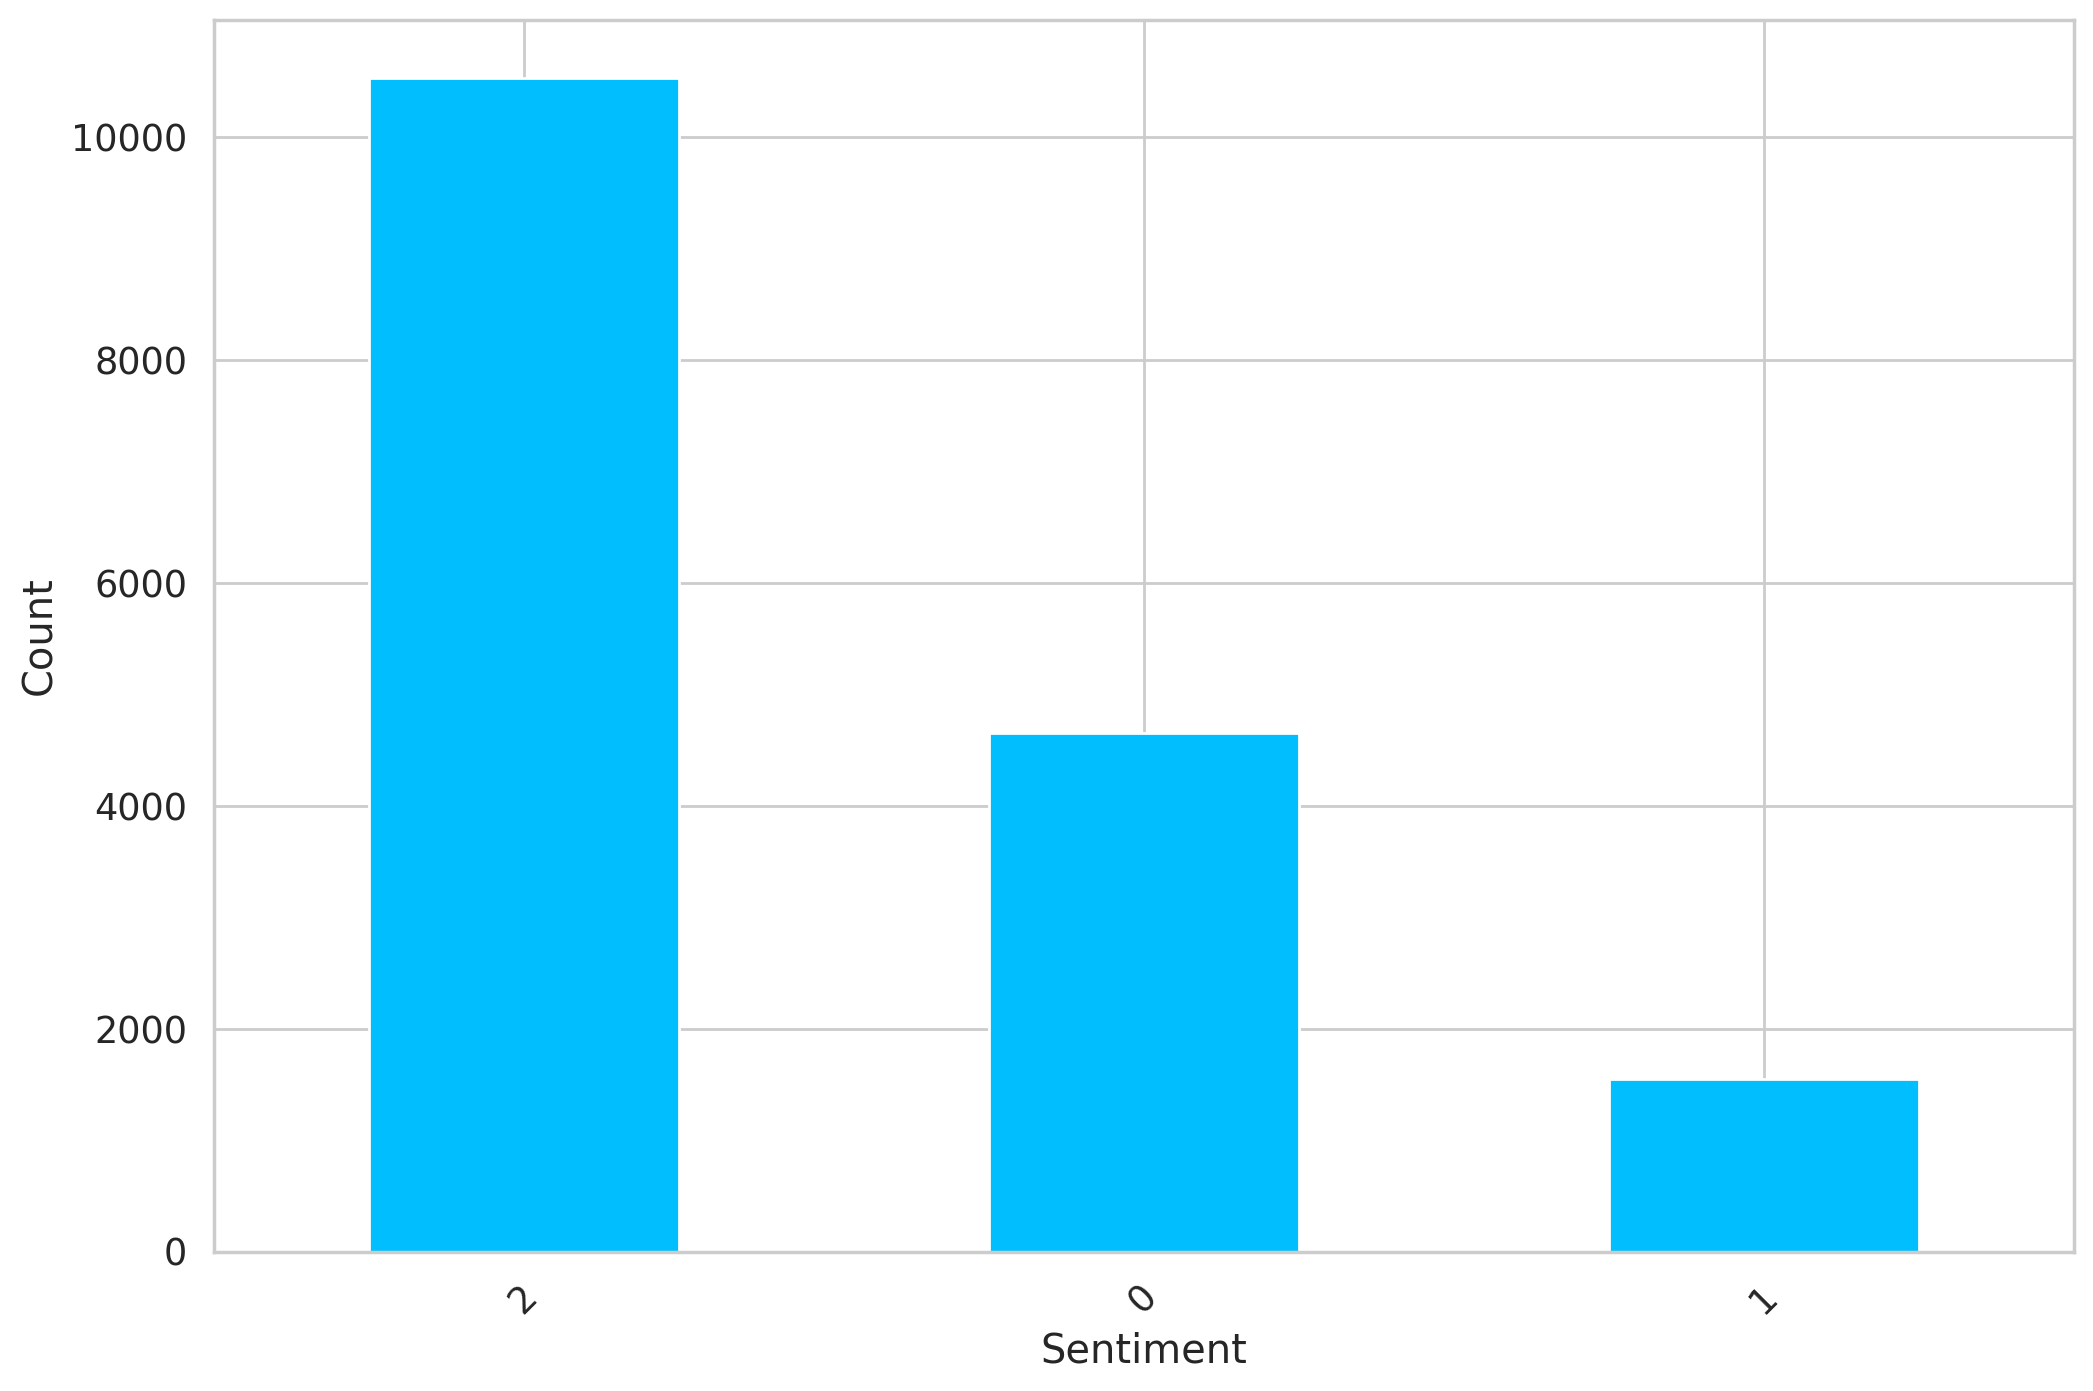

In [12]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
df.sentiment.value_counts().plot(kind= 'bar', y = class_names)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()


In [13]:
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer


In [14]:
# Set the model name
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 


</s> 2
<s> 0
<pad> 1
<unk> 3


In [16]:
df = df.dropna(subset=['content'])


In [17]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.content:
    
    tokens = tokenizer.encode_plus(txt, padding="max_length", truncation=True, max_length=160, return_tensors="pt")
    token_lens.append(len(tokens))


Text(0.5, 0, 'Token count')

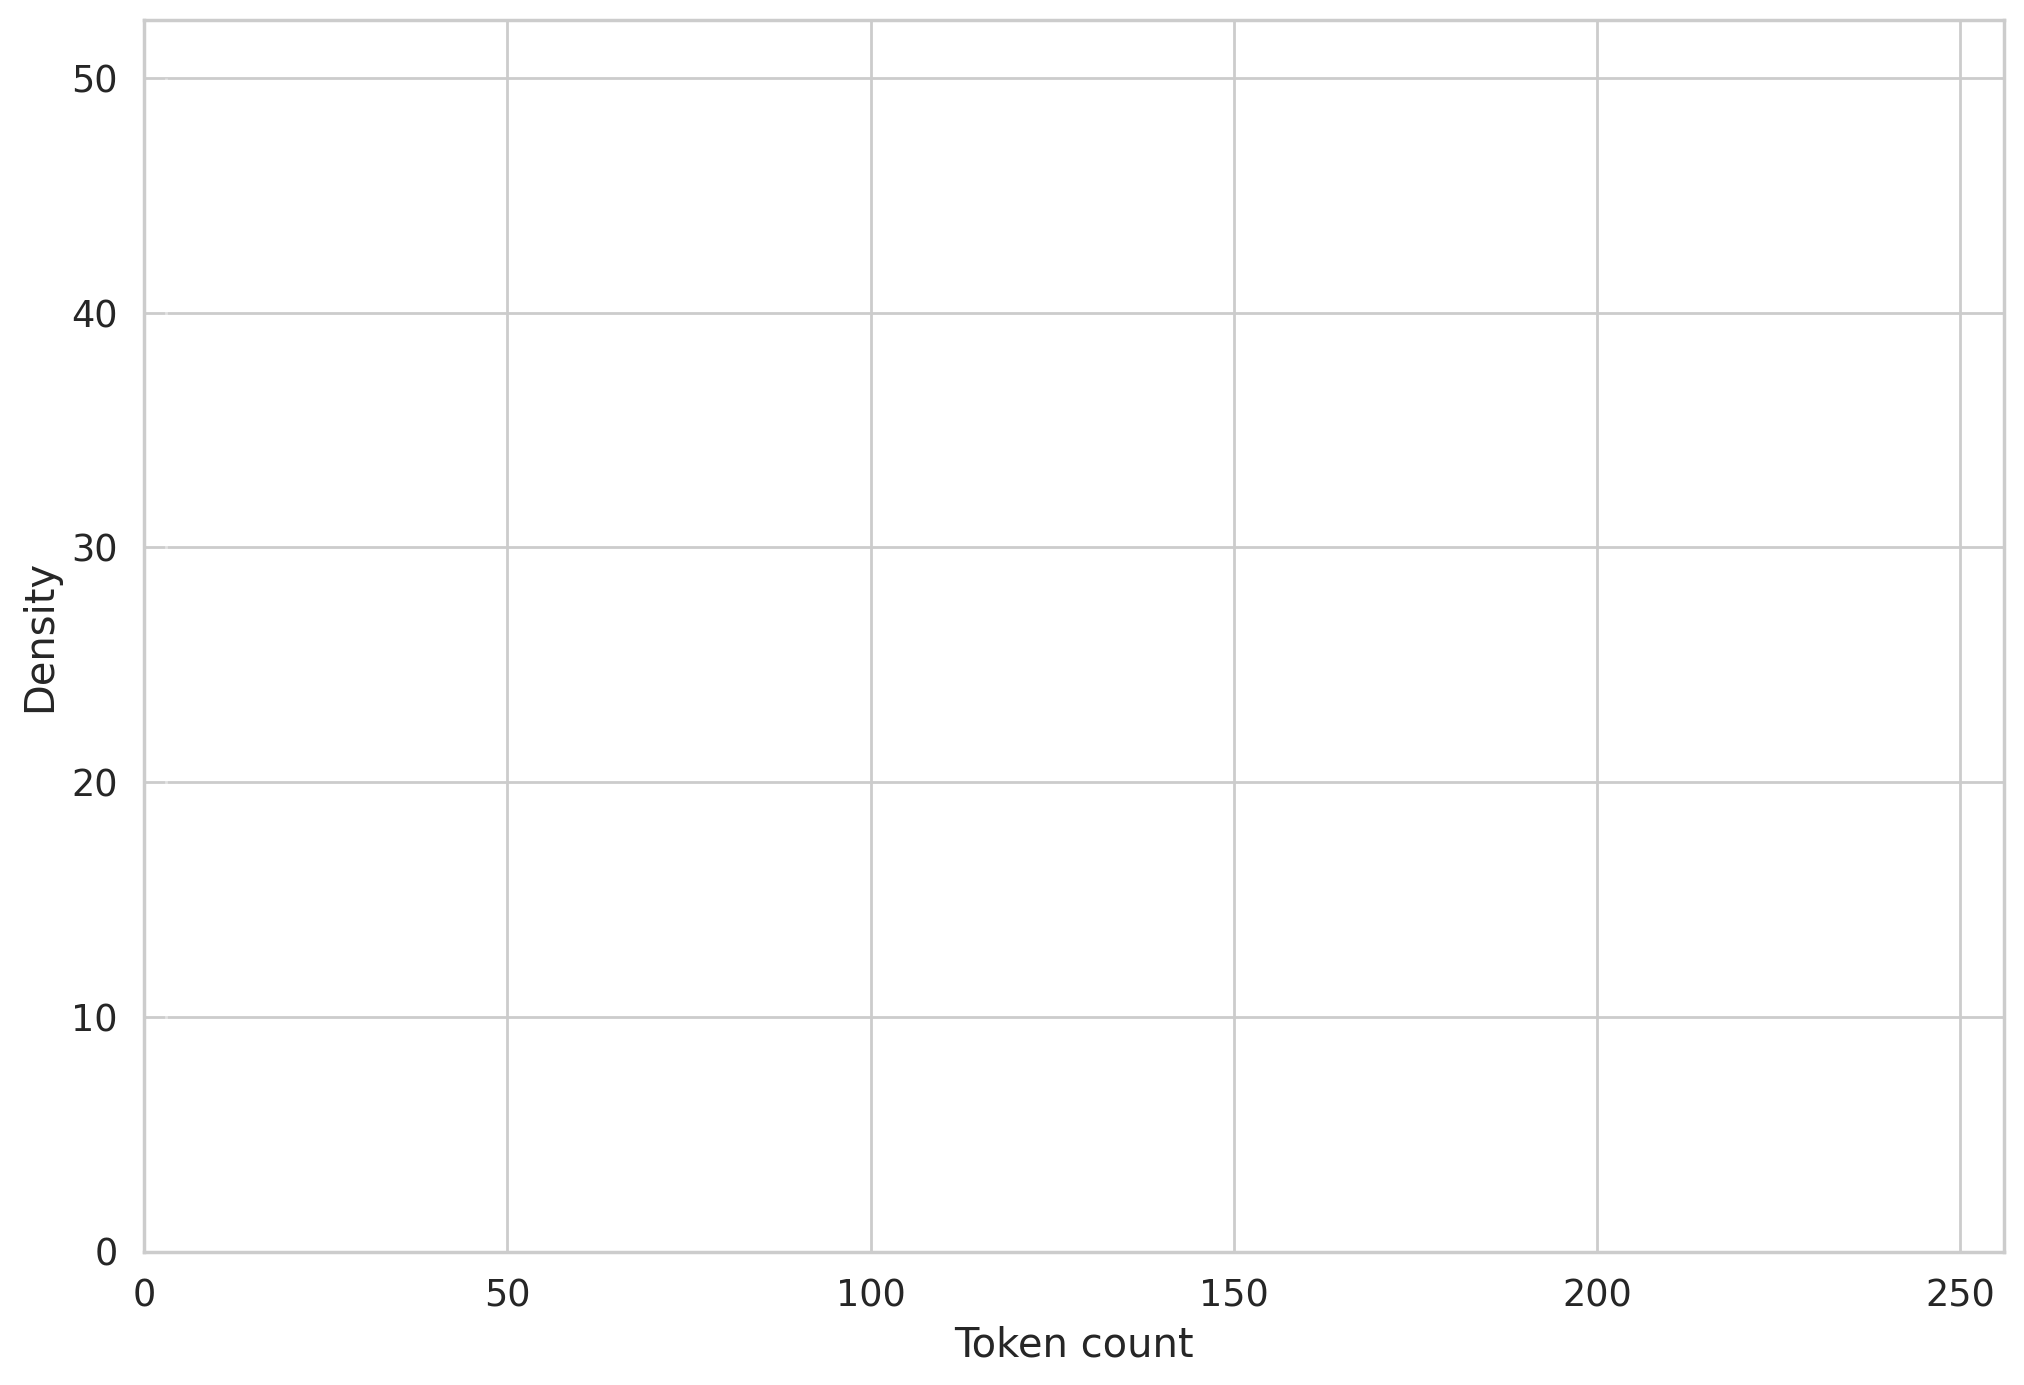

In [18]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')


In [19]:
MAX_LEN = 160


In [20]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [21]:
RANDOM_SEED = 10

In [22]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)


(13280, 13) (1660, 13) (1660, 13)


In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )


In [24]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [25]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [26]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
n_classes = 3

In [28]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.phobert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits


In [29]:
class_names

['negative', 'neutral', 'positive']

In [30]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
model

SentimentClassifier(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [32]:
model = model.to(device)


In [33]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)


        outputs = model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
def evaluation_metrics(preds, labels):
    '''
    Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - f1_score = 2 * precision * recall / (precision + recall)
    '''
    preds = preds.flatten()
    labels = labels.flatten()
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


In [35]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1_score = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
#             correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            eval_metrics = evaluation_metrics(np.array(preds.cpu()), np.array(targets.cpu()))

            # Calculate validation metrics
            accuracy, precision, recall, f1 = eval_metrics
            val_accuracy.append(accuracy)
            # Update precision only when (tp + fp) !=0; ignore nan
            if precision != 'nan': val_precision.append(precision)
            # Update recall only when (tp + fn) !=0; ignore nan
            if recall != 'nan': val_recall.append(recall)
            # Update specificity only when (tn + fp) !=0; ignore nan
            if f1 != 'nan': val_f1_score.append(f1)
            
    final_metrics = (sum(val_accuracy)/len(val_accuracy), sum(val_precision)/len(val_precision), 
                     sum(val_recall)/len(val_recall), sum(val_f1_score)/len(val_f1_score))
            
    return sum(val_accuracy)/len(val_accuracy), np.mean(losses), final_metrics


In [36]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)


In [37]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss:.4f} accuracy {train_acc:.4f}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss, eval_metrics = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    accuracy, precision, recall, f1 = eval_metrics
    
    print(f"Val   loss {val_loss:.4f} accuracy {val_acc:.4f}")
    print('\tVal Accuracy: {:.4f}'.format(accuracy))
    print('\tVal macro-Precision: {:.4f}'.format(precision))
    print('\tVal macro-Recall: {:.4f}'.format(recall))
    print('\tVal macro-F1-score: {:.4f}\n'.format(f1))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    history['accuracy'].append(accuracy)
    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1_score'].append(f1)
    
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7084 accuracy 0.7160
Val   loss 0.6419 accuracy 0.7644
	Val Accuracy: 0.7644
	Val macro-Precision: 0.5484
	Val macro-Recall: 0.5745
	Val macro-F1-score: 0.5473

Epoch 2/10
----------
Train loss 0.5957 accuracy 0.7815
Val   loss 0.6163 accuracy 0.7762
	Val Accuracy: 0.7762
	Val macro-Precision: 0.5656
	Val macro-Recall: 0.5923
	Val macro-F1-score: 0.5650

Epoch 3/10
----------
Train loss 0.5396 accuracy 0.8061
Val   loss 0.6758 accuracy 0.7632
	Val Accuracy: 0.7632
	Val macro-Precision: 0.5771
	Val macro-Recall: 0.5751
	Val macro-F1-score: 0.5551

Epoch 4/10
----------
Train loss 0.4878 accuracy 0.8297
Val   loss 0.7178 accuracy 0.7636
	Val Accuracy: 0.7636
	Val macro-Precision: 0.5801
	Val macro-Recall: 0.5789
	Val macro-F1-score: 0.5613

Epoch 5/10
----------
Train loss 0.4383 accuracy 0.8503
Val   loss 0.7734 accuracy 0.7570
	Val Accuracy: 0.7570
	Val macro-Precision: 0.5635
	Val macro-Recall: 0.5710
	Val macro-F1-score: 0.5497

Epoch 6/10
---------

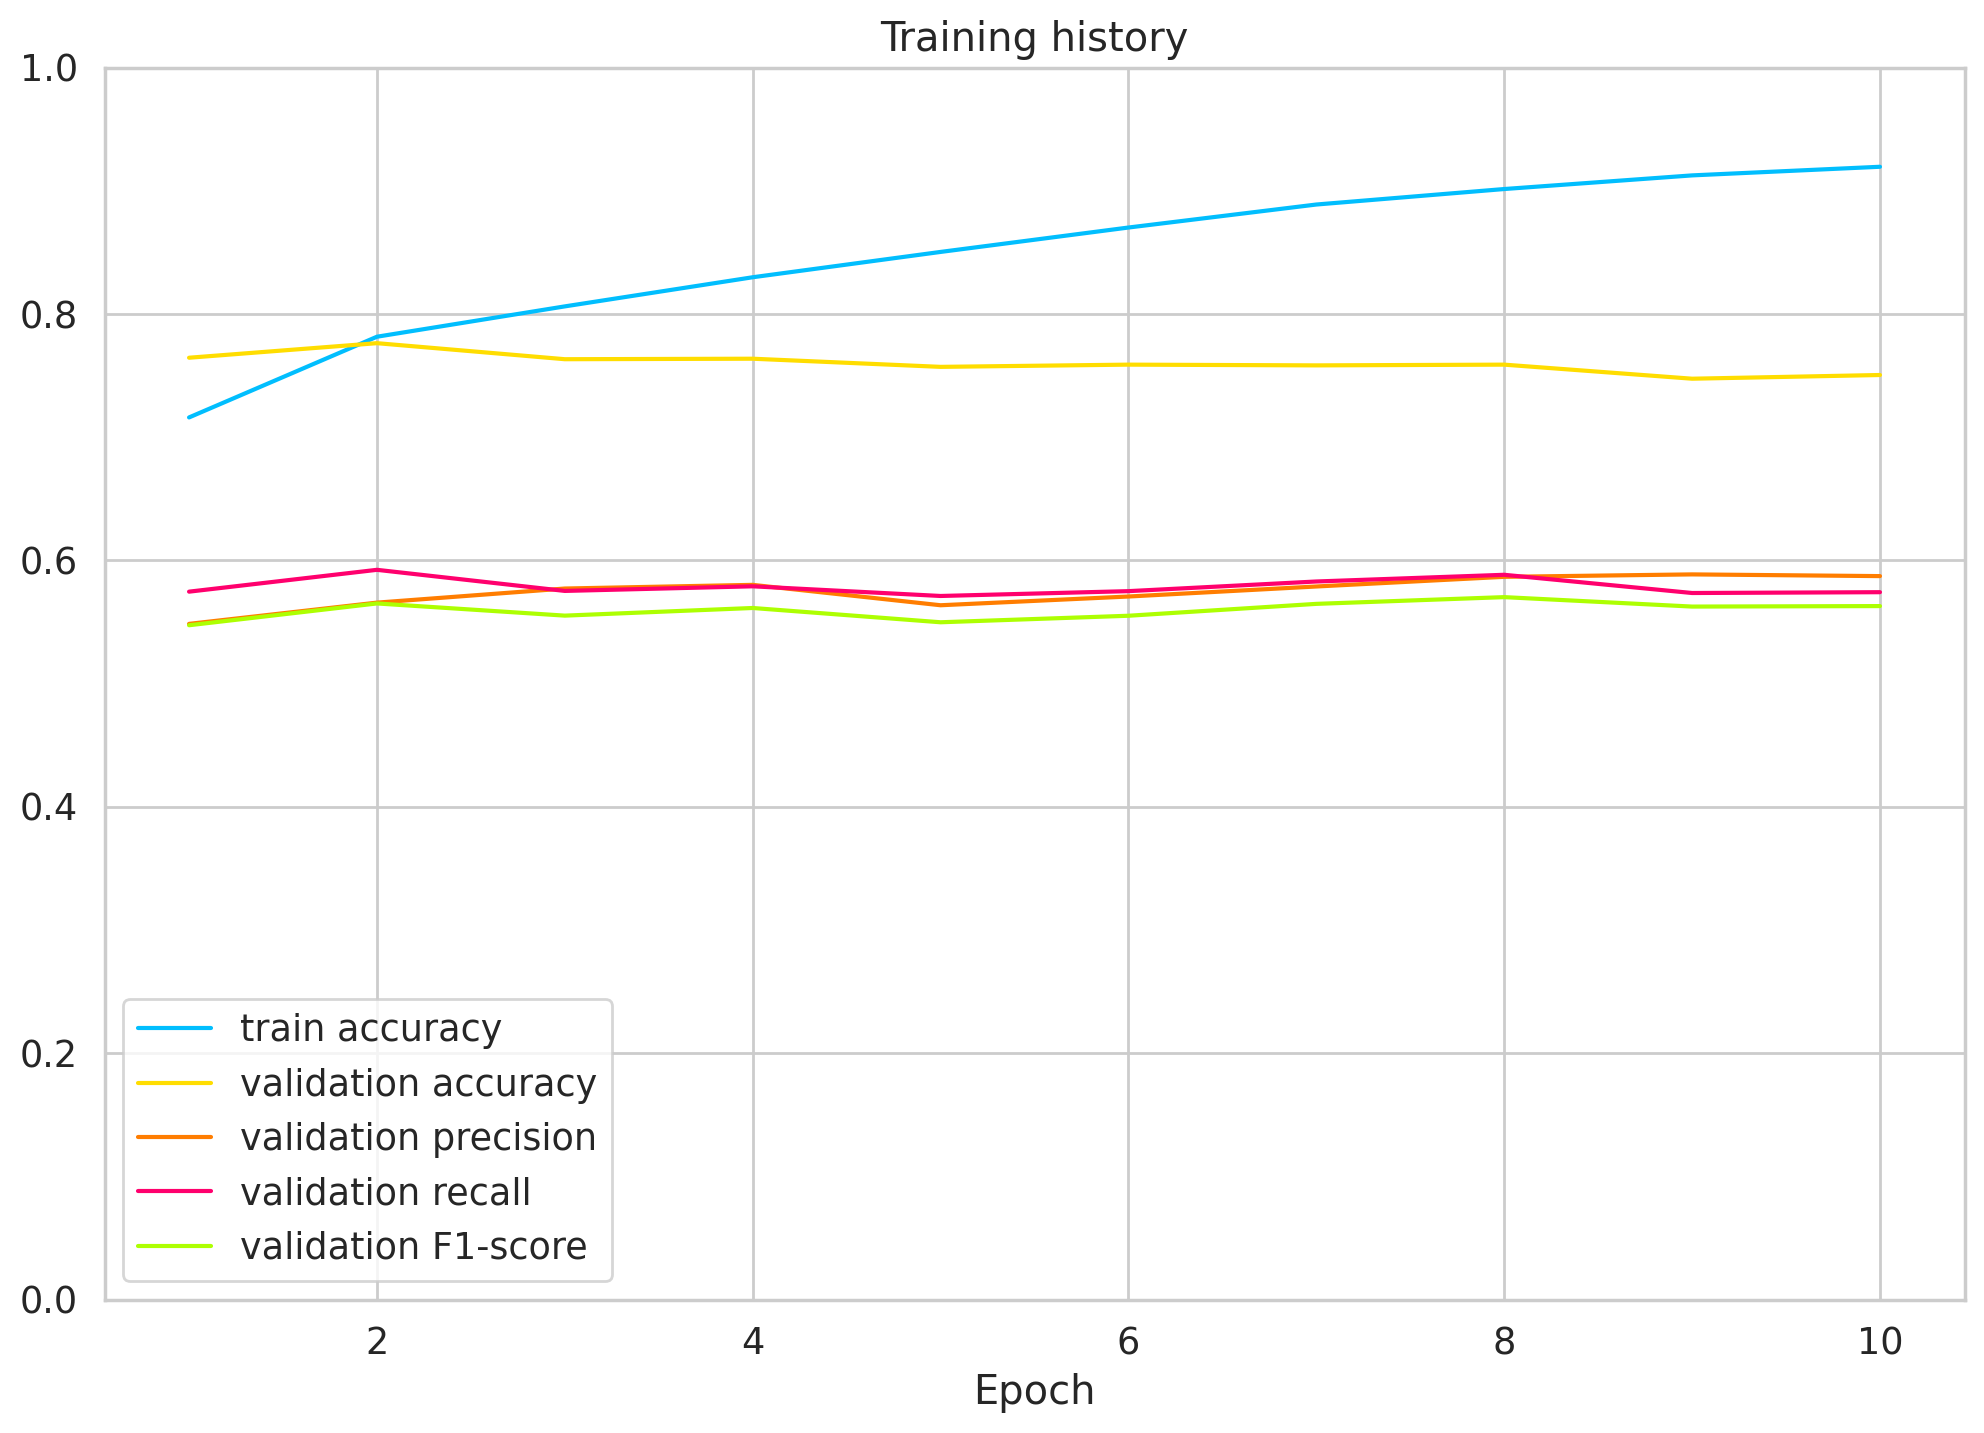

In [38]:
# Plot training and validation accuracy
train_acc = history['train_acc']
val_acc = history['val_acc']
train_acc = [float(i) for i in train_acc]
val_acc = [float(i) for i in val_acc]

x__ = range(1, EPOCHS + 1)

plt.plot(x__, train_acc, label='train accuracy')
plt.plot(x__, val_acc, label='validation accuracy')
plt.plot(x__, history['precision'], label='validation precision')
plt.plot(x__, history['recall'], label='validation recall')
plt.plot(x__, history['f1_score'], label='validation F1-score')


# Graph chars
plt.title('Training history')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


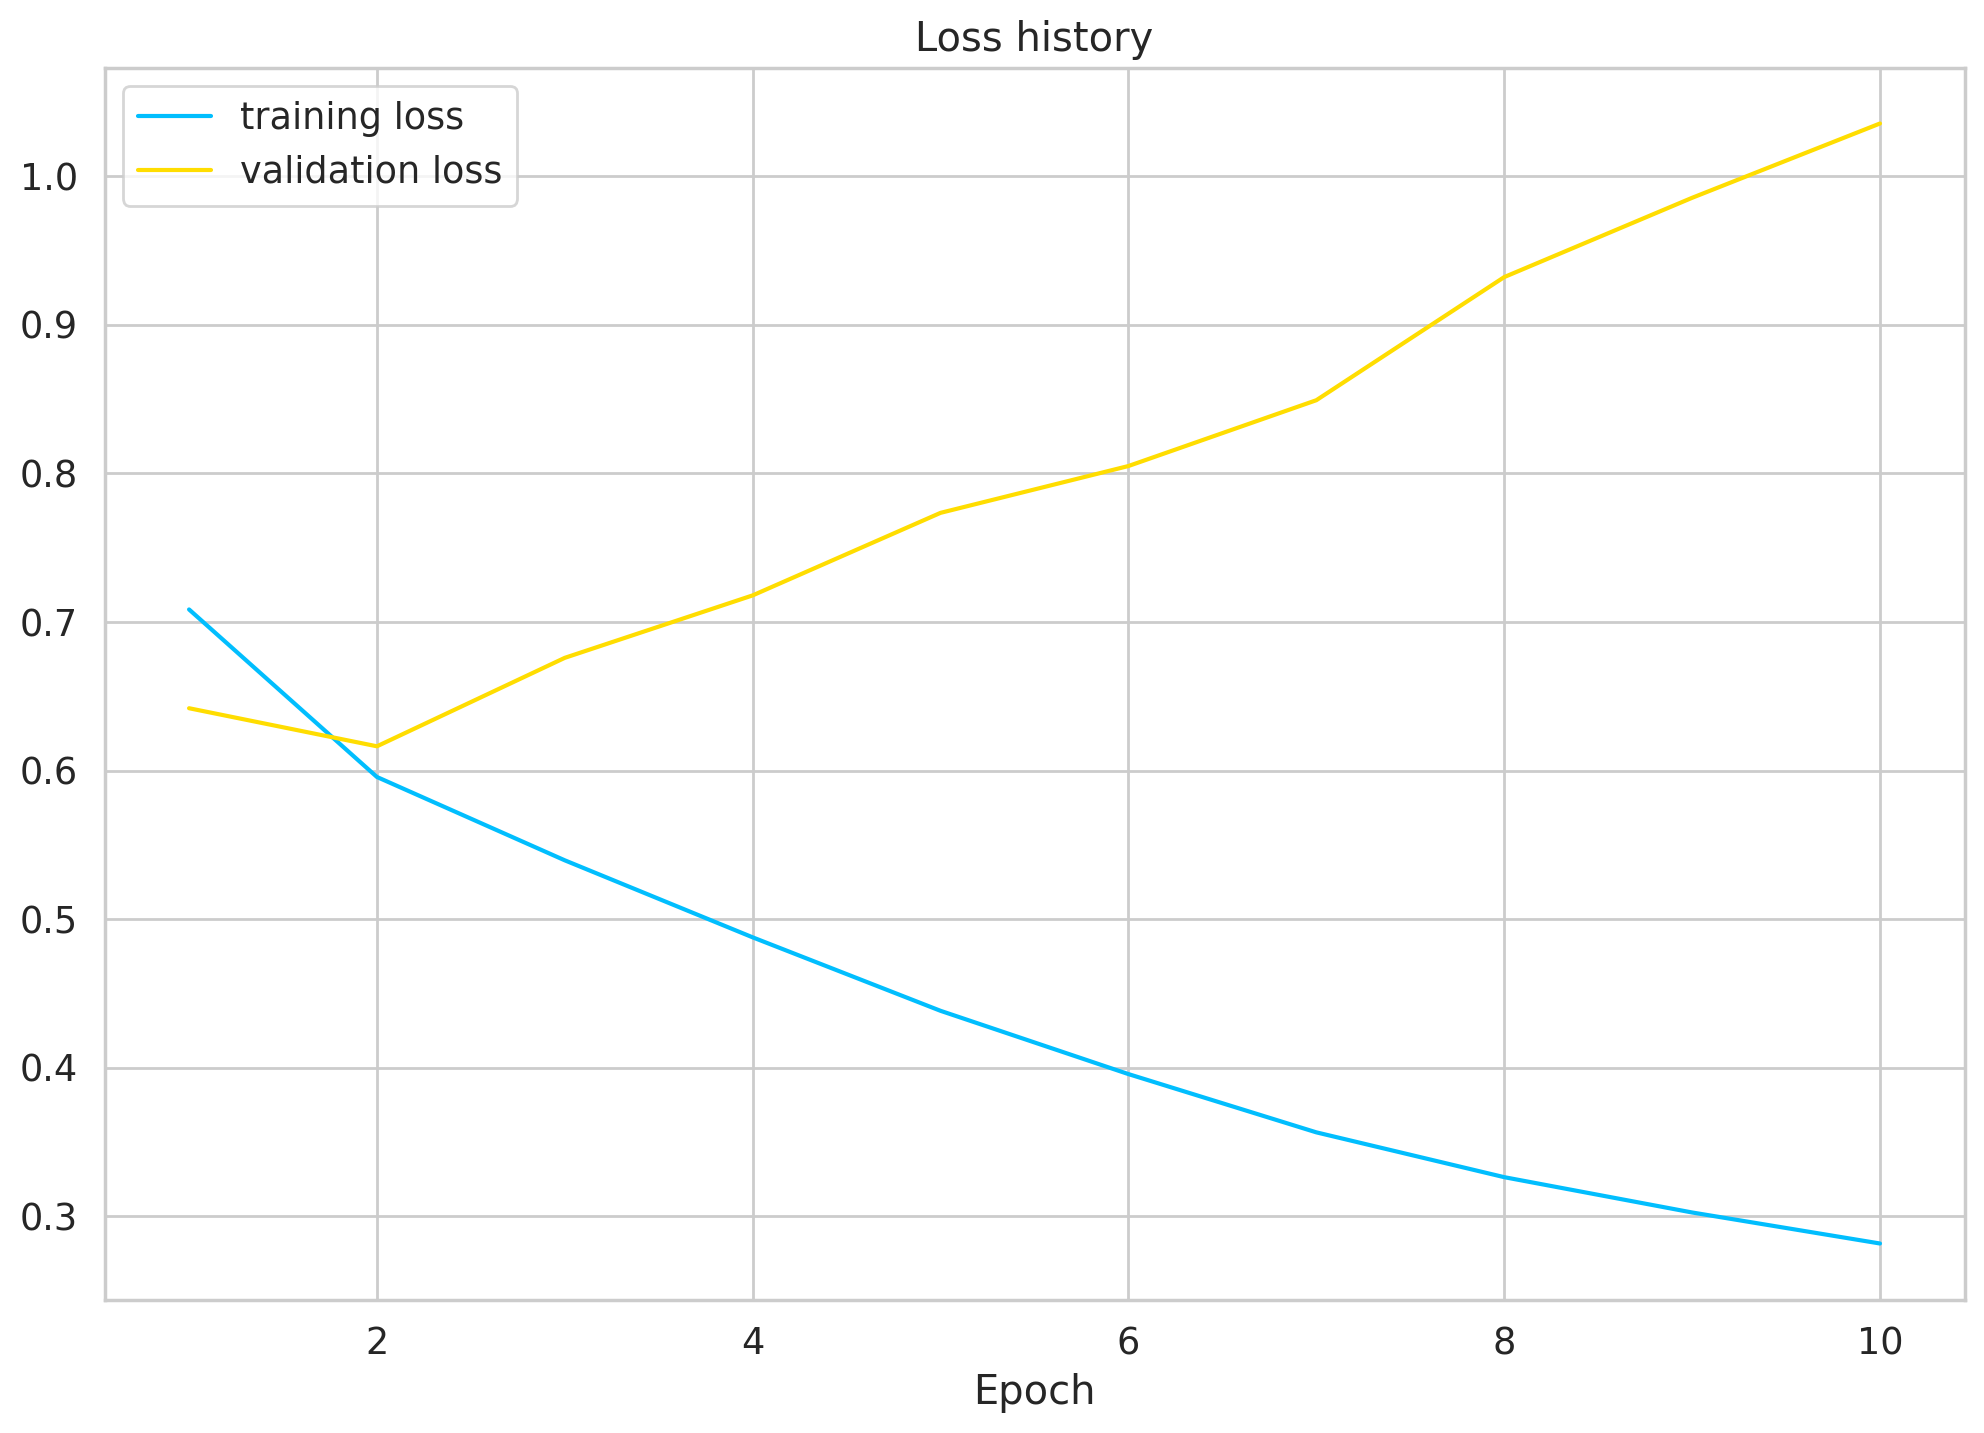

In [39]:
plt.plot(x__, history['train_loss'], label='training loss')
plt.plot(x__, history['val_loss'], label='validation loss')


# Graph chars
plt.title('Loss history')
plt.xlabel('Epoch')
plt.legend()


In [40]:
# Get model performance (accuracy and loss)
test_acc, test_loss, test_eval_metrics = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

accuracy, precision, recall, f1 = test_eval_metrics

print('Test Accuracy: {:.4f}'.format(accuracy))
print('Test macro-Precision: {:.4f}'.format(precision))
print('Test macro-Recall: {:.4f}'.format(recall))
print('Test macro-F1-score: {:.4f}\n'.format(f1))


Test Accuracy: 0.7414
Test macro-Precision: 0.5917
Test macro-Recall: 0.5751
Test macro-F1-score: 0.5637



In [41]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values


In [42]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)


In [43]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.70      0.61      0.65       467
     neutral       0.21      0.19      0.20       156
    positive       0.82      0.88      0.85      1037

    accuracy                           0.74      1660
   macro avg       0.58      0.56      0.57      1660
weighted avg       0.73      0.74      0.73      1660



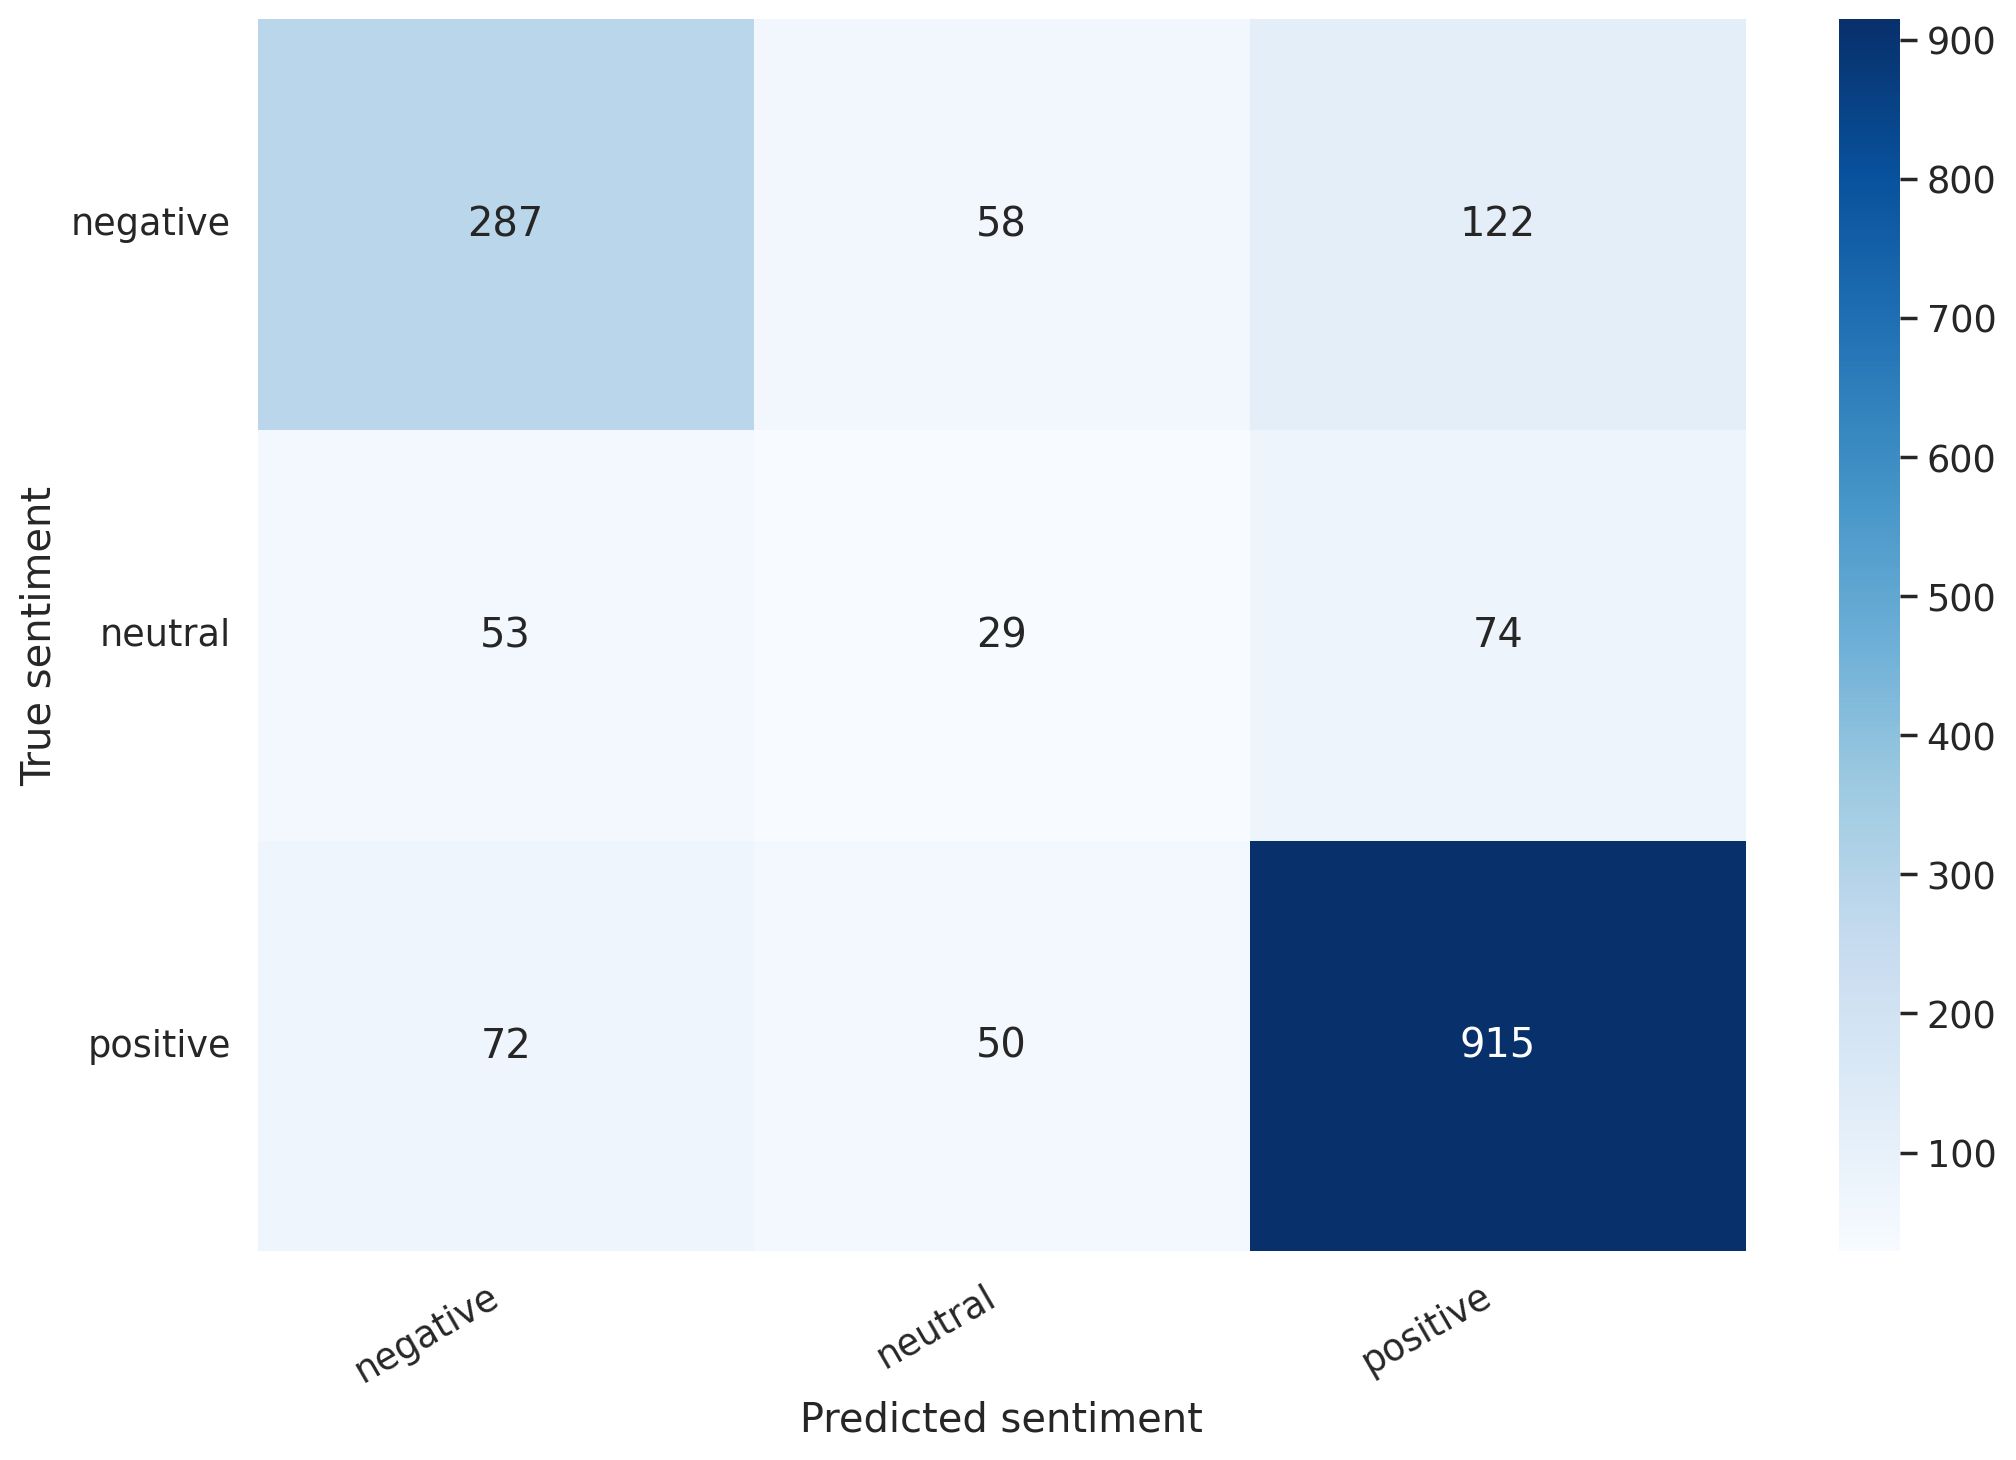

In [44]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


In [45]:
review_text = "App này không có nhiều tính năng nhưng vẫn hoạt động được"
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [46]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: App này không có nhiều tính năng nhưng vẫn hoạt động được
Sentiment  : positive


In [47]:
softmax = torch.nn.Softmax(dim=1)
output_ = softmax(output)


In [48]:
print(output_)


tensor([[0.0041, 0.0041, 0.9918]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
